In [1]:
!pip -q install tensorly

     |████████████████████████████████| 163kB 6.4MB/s 
     |████████████████████████████████| 163kB 40.8MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
%matplotlib inline
import csv
import os
import sys
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# Imported Libraries
import time
import gc
# Classifier Libraries
import collections
import warnings
import torch
import tensorly as tl
tl.set_backend('pytorch')
warnings.filterwarnings("ignore")
import statsmodels.api as sm
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM,MaxPooling2D,Conv2D,MaxPooling3D,Conv3D, Flatten, TimeDistributed, ConvLSTM2D, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression, ElasticNet
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor, GradientBoostingRegressor
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac
from tensorly.regression.tucker_regression import TuckerRegressor


In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Prefered Alam (Green Alarm)

In [5]:
root_folder="/content/drive/MyDrive/freelance_Ahamed"
def generate_stats(root_folder):
    green_alarms =["A1","A17","A19","A23","A25","A29","A35","A315"]
    files=os.listdir(root_folder)
    lst=[]
    for f in files:
        if os.path.isdir(os.path.join(root_folder,f)):
            pwd = os.path.join(root_folder,f)
            y = pd.read_csv(os.path.join(pwd,"y.csv"),header=None)
            labels=pd.read_csv(os.path.join(pwd,"classes.csv"),header=None)
            alrm='folder:'+f+' alarm'
            labels.columns=[alrm]
            fd = pd.DataFrame(np.zeros((len(labels),1)),columns=['count'])
            dfs = pd.concat([labels,fd], axis=1)
            for i,row in dfs.iterrows():
                cnt=np.sum(y==i)
                dfs.loc[i,'count']=cnt[0]
            lst.append(dfs)
    new_lst=[]
    for df in lst:
        s=pd.DataFrame(np.zeros(df.shape[0]),columns=['green_alarm'])
        s=pd.concat([df,s],axis=1)
        for i,row in df.iterrows():
            if row.iloc[0] in green_alarms:
                s.loc[i,'green_alarm']='green'
            else:
                s.loc[i,'green_alarm']='irrelevent'
        new_lst.append(s)
    return new_lst

In [ ]:
new_lst = generate_stats(root_folder)

In [ ]:
new_lst

[  folder:13 alarm   count green_alarm
 0             A33   302.0  irrelevent
 1            A502    11.0  irrelevent
 2             A69   302.0  irrelevent
 3          Normal  6150.0  irrelevent]

In [6]:
def load_data(root_folder):
    try:
        x_train = np.load(os.path.join(root_folder,'x_train_vec.npy'))
        x_test = np.load(os.path.join(root_folder,'x_test_vec.npy'))
        y_train = np.load(os.path.join(root_folder,'y_train_vec.npy'))
        y_test = np.load(os.path.join(root_folder,'y_test_vec.npy'))
    except:
        csv_to_numpy(root_folder,total_rows = 500)
        train_test_split_data(root_folder)
        x_train = np.load(os.path.join(root_folder,'x_train_vec.npy'))
        x_test = np.load(os.path.join(root_folder,'x_test_vec.npy'))
        y_train = np.load(os.path.join(root_folder,'y_train_vec.npy'))
        y_test = np.load(os.path.join(root_folder,'y_test_vec.npy'))
    return x_train,y_train,x_test,y_test

In [7]:
 
def break_csv(source_filepath, dest_path, result_filename_prefix, row_limit):
    """
    Break a source CSV into multiple CSVs of equal numbers of records,
    except the last file.
    The initial file's header row will be included as a header row in each split
    file.
    Split files follow a zero-index sequential naming convention like so:
        `{result_filename_prefix}_0.csv`
    :param source_filepath {str}:
        File name (including full path) for the file to be split.
    :param dest_path {str}:
        Full path to the directory where the split files should be saved.
    :param result_filename_prefix {str}:
        File name to be used for the generated files.
    :param row_limit {int}:
        Number of rows per file (header row is excluded from the row count).
    :return {NoneType}:
    """
    if row_limit <= 0:
        raise Exception('row_limit must be > 0')
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
    with open(source_filepath, 'r') as source:
        reader = csv.reader(source)
        headers = next(reader)
        file_number = 0
        records_exist = True
        while records_exist:
            i = 0
            target_filename = f'{result_filename_prefix}_{file_number}.csv'
            target_filepath = os.path.join(dest_path, target_filename)
            with open(target_filepath, 'w') as target:
                writer = csv.writer(target)
                while i < row_limit:
                    if i == 0:
                        writer.writerow(headers)
                    try:
                        writer.writerow(next(reader))
                        i += 1
                    except:
                        records_exist = False
                        break
            if i == 0:
                os.remove(target_filepath)
            file_number += 1

In [8]:
def csv_to_numpy(root_dir,total_rows = 500):
    source = os.path.join(root_dir,"X_range_local.csv")
    y_path = os.path.join(root_dir,"y.csv")
    try: 
        df = pd.read_csv(source)
        arr = np.array(df)
        arr_y = pd.read_csv(y_path)
    except:
        dest_x = os.path.join(root_dir,"new")
        filname_prefix = "X_range_local"
        break_csv(source, dest_x, filname_prefix, total_rows)
        os.remove(os.path.join(dest_y,"y_29.csv"))
        source_y = os.path.join(root_dir,"y.csv")
        dest_y = os.path.join(root_dir,"newest_y")
        filname_prefix_y = "y"
        break_csv(source_y, dest_y, filname_prefix_y, total_rows)
        os.remove(os.path.join(dest_x,"X_range_local_29.csv")) 

        pwd = os.path.join(root_dir,dest_x)
        filenames = os.listdir(pwd)
        np_dest_x =  os.path.join(root_dir,"X_range_np")
        print("="*29)
        if os.listdir(np_dest_x) ==[]:
            for f in filenames:
                df_mini = pd.read_csv(os.path.join(pwd,f))
                new_arr = np.array(df_mini)
                if not os.path.exists(np_dest_x):
                    os.mkdir(np_dest_x)
                np_path= f.split('_')[-1]
                np_path= os.path.join(np_dest_x,np_path.split('.')[0]+".npy")
                np.save(np_path,new_arr)
                print("=",end='')
        pwd = os.path.join(root_dir,dest_y)
        filenames = os.listdir(pwd)
        np_dest =  os.path.join(root_dir,"y_np")
        print("="*29)
        if os.listdir(np_dest) ==[]:
            for f in filenames:
                df_mini = pd.read_csv(os.path.join(pwd,f))
                new_arr = np.array(df_mini)
                if not os.path.exists(np_dest):
                    os.mkdir(np_dest)
                np_path= f.split('_')[-1]
                np_path= os.path.join(np_dest,np_path.split('.')[0]+".npy")
                np.save(np_path,new_arr)
                print("=",end='')
        pwd =  np_dest_x
        filenames = os.listdir(pwd)
        dirlist = sorted_alphanumeric(filenames)
        dirlist.reverse()
        arr = np.array([])
        print("="*20)

        for f in dirlist[9:]:
            path_new=os.path.join(os.path.join(pwd,f))
            s=np.load(path_new)
            if len(arr.shape) < 2:
                arr = s
            elif arr.shape[0]==10000:
                break
            else:
                arr=np.vstack([s,arr])
            del s
            gc.collect()
            print("=",end='')
        pwd = np_dest
        filenames = os.listdir(pwd)
        dirlist = sorted_alphanumeric(filenames)
        dirlist.reverse()
        arr_y = np.array([])
        print("="*20)
        for f in dirlist[9:]:
            path_new=os.path.join(os.path.join(pwd,f))
            s=np.load(path_new)
            if arr_y.shape == (0,):
                arr_y = s
            elif arr_y.shape[0]==10000:
                break
            else:
                arr_y=np.vstack([s,arr_y])
            del s
            gc.collect()
            print("=",end='')
    np_save_path_x = os.path.join(root_dir,'X_range_local_10k.npy')
    np.save(np_save_path_x,arr)
    np_save_path_y = os.path.join(root_dir,'y2_10k.npy')
    np.save(np_save_path_y,arr_y)
    print(np_save_path_x,np_save_path_y)


In [9]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


In [10]:
def train_test_split_data(root_dir):
    arr = np.load(os.path.join(root_dir,'X_range_local_10k.npy'))
    arr_y = np.load(os.path.join(root_dir,'y2_10k.npy'))
    time =  pd.read_csv(os.path.join(root_dir,"times_id.csv"),header=None)
    feature =  pd.read_csv(os.path.join(root_dir,"features_id.csv"),header=None)
    time = np.max(np.asarray(time))
    feature = np.max(np.asarray(feature))
    arr = arr.reshape(arr.shape[0],feature,time)
    x_train, x_test, y_train, y_test = train_test_split(arr, arr_y, test_size=0.3, random_state=42, shuffle = False) #Balaji Edit
    np_path=root_dir
    np.save(os.path.join(np_path,'x_train_vec.npy'),x_train)
    np.save(os.path.join(np_path,'x_test_vec.npy'),x_test)
    np.save(os.path.join(np_path,'y_train_vec.npy'),y_train)
    np.save(os.path.join(np_path,'y_test_vec.npy'),y_test)


Vector Regression

In [11]:
def train_test_divide(x,y,test_size=0.2):
    y=np.array(y,dtype=np.double)
    # Duplicating data for small number of samples
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,shuffle=False, random_state=22) # Balaji Edit
    return x_train,x_test,y_train,y_test


In [12]:
def divide_into_windows(X, tg=5, window=30, detail=1):
    if detail:
        print("Dividing the X data into windows")
        print("Original shape (features, time):",X.shape)
    sample_time = 5
    X=np.mean(X.reshape(X.shape[0], X.shape[1]//tg, tg), axis=2)
    if detail:
        print("Time granuality by taking average of every",str(tg*sample_time),"seconds, \nNew shape (features, time):",X.shape)
    Y= np.array([y for y in range((720-tg*window)*sample_time,-1,-sample_time*tg*window)]).reshape(-1,1)
    X=X.reshape(X.shape[0],window,X.shape[1]//window)
    if detail:
        print("Dividing the data into windows of",str(window),"samples each, total windows:",X.shape[2])
        print("New shape (features, time, windows):",X.shape)
    X=X.reshape(X.shape[0]*X.shape[1],X.shape[2])
    if detail:
        print("Multiply feature dimension with time, \nNew shape (features * time, windows):", X.shape)
    X=X.T
    if detail:
        print("After applying time granuality and window split, \nNew shape of X (windows, features * time):",X.shape)
        print("Shape of Y created using X:",Y.shape)
    return X,np.array(Y)

In [13]:
import matplotlib.pyplot as plt # Impot the relevant module
def plot_x(pred, original, alarm):
  pred = torch.tensor(pred,device='cpu')
  original = torch.tensor(original,device='cpu')

  # print('Predicted And Original Values:\n',torch.hstack([original.reshape(original.shape[0],1),pred.reshape(pred.shape[0],1)]))
  fig, ax = plt.subplots(figsize=(18,6)) # Create the figure and axes object
  x = [*range(0,pred.shape[0],1)]
  x = torch.tensor(x,device='cpu')

  # Plot the first x and y axes:
  ax.plot(x, pred, 'o-')
  ax.plot(x ,original, 'r')
  ax.set_xlabel('Samples')
  ax.set_ylabel('Time till Alarm')
  fig.suptitle(alarm)
  ax.legend(['Predictions','Original'])
  fig.show()
  plt.show()
  plt.pause(0.0001) #add this it will be OK.
  fig.savefig(alarm+'.jpg')


In [14]:
# Returns only the alarm samples in the dataset
def select_alarms(X,Y,alarm_select=None):
    new_X=[]
    new_Y=[]
    if alarm_select is not None:
        X=X[(Y.T!=np.max(Y))[0]]
        Y=Y[(Y.T!=np.max(Y))[0]].T
        if alarm_select in set(np.ravel(Y)):
            new_X.append(X[(Y==alarm_select)[0]])
            new_Y.append(Y[0][(Y==alarm_select)[0]])
        return np.array(new_X), np.array(new_Y)

    X=X[(Y.T!=np.max(Y))[0]]
    Y=Y[(Y.T!=np.max(Y))[0]].T
    for i in set(np.ravel(Y)):
        new_X.append(X[(Y==i)[0]])
        new_Y.append(Y[0][(Y==i)[0]])
    return np.array(new_X), np.array(new_Y)

In [15]:
# given alarm samples divide into vectors and generate regression labels, returns dictionary with alarm index and x,y
def divide_and_create_lr_datasets(xe,ye,tg=5, window=30, detail=1):
    alarms_dict={}
    for x,y in zip(xe,ye):
        new_x=[]
        new_y=[]
        if x.shape[0]==1:
            x=x[0]
            new_x,new_y=divide_into_windows(x,tg=tg, window=window, detail=detail)
        else:
            for xi,yi in zip(x,y):
                if np.shape(new_x)[0]==0:
                    new_x,new_y=divide_into_windows(xi,tg=tg, window=window, detail=detail)
                else:
                    new_x=np.vstack([new_x,divide_into_windows(xi,tg=tg, window=window, detail=detail)[0]])
                    new_y=np.vstack([new_y,divide_into_windows(xi,tg=tg, window=window, detail=detail)[1]])
        alarms_dict.update({y[0]:(new_x,new_y)})
    return alarms_dict

In [16]:
# Selects alarm samples and divides them into windows
def preprocess_for_lr(X,Y,tg=5, window=30,detail=1,alarm_select=None):
    xe,ye=select_alarms(X,Y,alarm_select=alarm_select)
    alarm_dataset = divide_and_create_lr_datasets(xe,ye,tg=tg, window=window, detail=detail)
    return alarm_dataset

Tensor Regression

In [17]:
def train_test_divide_tensor(x,y,test_size=0.2):
    y=np.array(y,dtype=np.double)
    y=torch.tensor(y)
    # Duplicating data for small number of samples
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,shuffle=False, random_state=22) # Why was shuffle True here? Balaji Edits
    return x_train,x_test,y_train,y_test

In [18]:
# Takes n-dimension array and hankelizes it by adding a lag dimension
def hankelize(X, lag=5):
    samples = X.shape[0]
    time_samples=X.shape[-1]//lag
    x_hankelized = np.zeros((samples,X.shape[1],X.shape[2],time_samples))
    step_size = X.shape[2]//time_samples
    for i in range(samples):
        for j in range(X.shape[1]):
            x_t = X[i,j,:]
            x = np.zeros((time_samples,X.shape[2]))
            for k in range(time_samples):
                x_hankelized[i,j,:,k]=np.hstack([x_t[k*step_size:],np.zeros((k*step_size))])  
    return torch.tensor(x_hankelized,device='cuda')

In [19]:
# checking purpose 
X= np.array(range(100)).reshape(2,5,10)
h=hankelize(X,lag=2)

In [ ]:
h

tensor([[[[ 0.,  2.,  4.,  6.,  8.],
          [ 1.,  3.,  5.,  7.,  9.],
          [ 2.,  4.,  6.,  8.,  0.],
          [ 3.,  5.,  7.,  9.,  0.],
          [ 4.,  6.,  8.,  0.,  0.],
          [ 5.,  7.,  9.,  0.,  0.],
          [ 6.,  8.,  0.,  0.,  0.],
          [ 7.,  9.,  0.,  0.,  0.],
          [ 8.,  0.,  0.,  0.,  0.],
          [ 9.,  0.,  0.,  0.,  0.]],

         [[10., 12., 14., 16., 18.],
          [11., 13., 15., 17., 19.],
          [12., 14., 16., 18.,  0.],
          [13., 15., 17., 19.,  0.],
          [14., 16., 18.,  0.,  0.],
          [15., 17., 19.,  0.,  0.],
          [16., 18.,  0.,  0.,  0.],
          [17., 19.,  0.,  0.,  0.],
          [18.,  0.,  0.,  0.,  0.],
          [19.,  0.,  0.,  0.,  0.]],

         [[20., 22., 24., 26., 28.],
          [21., 23., 25., 27., 29.],
          [22., 24., 26., 28.,  0.],
          [23., 25., 27., 29.,  0.],
          [24., 26., 28.,  0.,  0.],
          [25., 27., 29.,  0.,  0.],
          [26., 28.,  0.,  0.,  0.

In [20]:
# Divide dataset into windows and hankelize it
def divide_into_windows_and_hankle(X, tg=6, window=24, lag=5, detail=1):
    if detail:
        print("\nDividing the X data into windows, \nOriginal shape (features, time):",X.shape)
    sample_time = 5
    X=np.mean(X.reshape(X.shape[0], X.shape[1]//tg, tg), axis=2)
    if detail:
        print("Time granuality by taking average of every",str(tg*sample_time),"seconds, \nNew shape (features, time):",X.shape)
    Y= np.array([y for y in range((720-tg*window)*sample_time,-1,-sample_time*tg*window)]).reshape(-1,1)
    X=X.reshape(X.shape[0],window,X.shape[1]//window)
    if detail:
        print("Dividing the data into windows of",str(window),"samples each, total windows:",X.shape[2])
        print("New shape (features, time, windows):",X.shape)
    X=X.transpose([2,0,1])
    if detail:
        print("Transposing the dimensions for tensor regression, \nNew shape (windows, features, time):", X.shape)
    x_hankelized = hankelize(X, lag=lag)
    if detail:
        print("Hankelizing with lag in samples:",lag,"\nNew shape (windows, features, time, lag):",x_hankelized.cpu().numpy().shape)
    if detail:
        print("New shape of X after applying time granuality and window split,\
         \nNew shape (windows, features, time, lag):",x_hankelized.cpu().numpy().shape)
        print("Shape of Y created using X:",Y.shape)
    return torch.tensor(x_hankelized,device='cuda'),torch.tensor(Y,device='cuda')

In [21]:
# checking purpose 
X= np.array(range(58*720)).reshape(58,720)
X

array([[    0,     1,     2, ...,   717,   718,   719],
       [  720,   721,   722, ...,  1437,  1438,  1439],
       [ 1440,  1441,  1442, ...,  2157,  2158,  2159],
       ...,
       [39600, 39601, 39602, ..., 40317, 40318, 40319],
       [40320, 40321, 40322, ..., 41037, 41038, 41039],
       [41040, 41041, 41042, ..., 41757, 41758, 41759]])

In [ ]:


X,Y=divide_into_windows_and_hankle(X,tg=6,window=24)


Dividing the X data into windows, 
Original shape (features, time): (58, 720)
Time granuality by taking average of every 30 seconds, 
New shape (features, time): (58, 120)
Dividing the data into windows of 24 samples each, total windows: 5
New shape (features, time, windows): (58, 24, 5)
Transposing the dimensions for tensor regression, 
New shape (windows, features, time): (5, 58, 24)
Hankelizing with lag in samples: 5 
New shape (windows, features, time, lag): (5, 58, 24, 4)
New shape of X after applying time granuality and window split,         
New shape (windows, features, time, lag): (5, 58, 24, 4)
Shape of Y created using X: (5, 1)


In [22]:
# Create a dataset for tensor regression using helper functions
def divide_and_create_tr_datasets(xe,ye,tg=5, window=30, lag=5,detail=1):
    alarms_dict={}
    for x,y in zip(xe,ye):
        new_x=[]
        new_y=[]
        if x.shape[0]==1:
            x=x[0]
            new_x,new_y=divide_into_windows_and_hankle(x, tg=tg, window=window, lag=lag, detail=detail)
        else:
            for xi,yi in zip(x,y):
                if np.shape(new_x)[0]==0:
                    new_x,new_y=divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)
                else:
                    new_x=torch.vstack([new_x,divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)[0]])
                    new_y=torch.vstack([new_y,divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)[1]])
        alarms_dict.update({y[0]:(new_x,new_y)})
    return alarms_dict


In [23]:
# Select alarms from main dataset, divide into windows and hankelize it
def preprocess_hanklize_tensors(X,y,window=30,tg=10,lag=30, detail=1):
    X,y=select_alarms(X,y)
    alarm_ds=divide_and_create_tr_datasets(X,y,tg=tg, window=window, lag=lag, detail=detail)
    return alarm_ds

Matrix Regression


In [24]:
def divide_into_windows_matrix(X, tg=5, window=30, detail=1):
    if detail:
        print("\nDividing the X data into windows, \nOriginal shape (features, time):",X.shape)
    sample_time = 5
    X=np.mean(X.reshape(X.shape[0], X.shape[1]//tg, tg), axis=2)
    if detail:
        print("Time granuality by taking average of every",str(tg*sample_time),"seconds, \nNew shape (features, time):",X.shape)
    Y= np.array([y for y in range((720-tg*window)*sample_time,-1,-sample_time*tg*window)]).reshape(-1,1)
    X=X.reshape(X.shape[0],window,X.shape[1]//window)
    if detail:
        print("Dividing the data into windows of",str(window),"samples each, total windows:",X.shape[2])
        print("New shape (features, time, windows):",X.shape)
    if detail:
        print("Transposing the dimensions for tensor regression, \nNew shape (windows, features, time):", X.shape)
    X=X.transpose([2,0,1])
    if detail:
        print("New shape of X after applying time granuality and window split, \nNew shape (windows, features, time):",X.shape)
        print("Shape of Y created using X:",Y.shape)
    return torch.tensor(X,device='cuda'),torch.tensor(Y,device='cuda')

In [25]:
# Create a dataset for tensor regression using helper functions
def divide_and_create_matrix_datasets(xe,ye,tg=5, window=30, detail=1):
    alarms_dict={}
    for x,y in zip(xe,ye):
        new_x=[]
        new_y=[]
        if x.shape[0]==1:
            x=x[0]
            
            new_x,new_y=divide_into_windows_matrix(x, tg=tg, window=window, detail=detail)
        else:
            for xi,yi in zip(x,y):
                if np.shape(new_x)[0]==0:
                    print(xi.shape)
                    new_x,new_y=divide_into_windows_matrix(xi, tg=tg, window=window, detail=detail)
                else:
                    new_x=torch.vstack([new_x,divide_into_windows_matrix(xi, tg=tg, window=window, detail=detail)[0]])
                    new_y=torch.vstack([new_y,divide_into_windows_matrix(xi, tg=tg, window=window, detail=detail)[1]])
        alarms_dict.update({y[0]:(new_x,new_y)})
    return alarms_dict


In [26]:
# Select alarms from main dataset, divide into windows and hankelize it
def preprocess_hanklize_matrix(X,y,window=30,tg=5, detail=1):
    X,y=select_alarms(X,y)
    alarm_ds=divide_and_create_matrix_datasets(X,y,window=window,tg=tg, detail=detail)
    return alarm_ds

Train Vector Regression

In [27]:
def train_lr_cv(x_train,y_train,cv=5): 
    lr = LinearRegression()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    try:
        grid = GridSearchCV(lr,parameters, cv=cv)
        grid.fit(x_train,y_train)
    except:
        grid = GridSearchCV(lr,parameters, cv=None)
        print(x_train.shape,y_train.shape)
        grid.fit(x_train,y_train)                    
    lr= grid.best_estimator_
    lr.fit(x_train, y_train)
    # Cross validation 
    """    
    ss = ShuffleSplit(n_splits=5, test_size=0.2)
    maes = []
    for train_index, test_index in ss.split(x_train):
        lr.fit(x_train[train_index],y_train[train_index])
        pred_cv=lr.predict(x_train[test_index])
        pred_cv = np.maximum(pred_cv,0)
        pred_cv[pred_cv>3600]=3600
        maes.append(mean_absolute_error(pred_cv,y_train[test_index]))"""
    return lr#, torch.mean(torch.tensor(maes)).cpu().numpy()

In [28]:
def train_lr_cv(x_train,y_train,cv=5): 
    lr = Lasso()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    try:
        grid = GridSearchCV(lr,parameters, cv=cv)
        grid.fit(x_train,y_train)
    except:
        grid = GridSearchCV(lr,parameters, cv=None)
        print(x_train.shape,y_train.shape)
        grid.fit(x_train,y_train)                    
    lr= grid.best_estimator_
    
    # Cross validation 
    ss = ShuffleSplit(n_splits=5, test_size=0.2)
    maes = []
    for train_index, test_index in ss.split(x_train):
        lr.fit(x_train[train_index],y_train[train_index])
        pred_cv=lr.predict(x_train[test_index])
        pred_cv = np.maximum(pred_cv,0)
        pred_cv[pred_cv>3600]=3600
        maes.append(mean_absolute_error(pred_cv,y_train[test_index]))
    return lr, torch.mean(torch.tensor(maes)).cpu().numpy()

In [29]:
#### Balaji Edits - Ridge 
def train_lr_cv(x_train,y_train,cv=5): 
    lr = Ridge()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    try:
        grid = GridSearchCV(lr,parameters, cv=cv)
        grid.fit(x_train,y_train)
    except:
        grid = GridSearchCV(lr,parameters, cv=None)
        print(x_train.shape,y_train.shape)
        grid.fit(x_train,y_train)                    
    lr= grid.best_estimator_
    
    # Cross validation 
    ss = ShuffleSplit(n_splits=5, test_size=0.2)
    maes = []
    for train_index, test_index in ss.split(x_train):
        lr.fit(x_train[train_index],y_train[train_index])
        pred_cv=lr.predict(x_train[test_index])
        pred_cv = np.maximum(pred_cv,0)
        pred_cv[pred_cv>3600]=3600
        maes.append(mean_absolute_error(pred_cv,y_train[test_index]))
    return lr, torch.mean(torch.tensor(maes)).cpu().numpy()

In [30]:
#### Balaji Edits - RandomForest Regressor
def train_lr_cv(x_train,y_train,cv=5): 
    lr = RandomForestRegressor(criterion = 'mae', verbose = 1)
    parameters = {'max_features':["auto", "sqrt", "log2"]}
    try:
        grid = GridSearchCV(lr,parameters, cv=cv)
        grid.fit(x_train,y_train)
    except:
        grid = GridSearchCV(lr,parameters, cv=None)
        print(x_train.shape,y_train.shape)
        grid.fit(x_train,y_train)                    
    lr= grid.best_estimator_
    
    # Cross validation 
    ss = ShuffleSplit(n_splits=5, test_size=0.2)
    maes = []
    for train_index, test_index in ss.split(x_train):
        lr.fit(x_train[train_index],y_train[train_index])
        pred_cv=lr.predict(x_train[test_index])
        pred_cv = np.maximum(pred_cv,0)
        pred_cv[pred_cv>3600]=3600
        maes.append(mean_absolute_error(pred_cv,y_train[test_index]))
    return lr, torch.mean(torch.tensor(maes)).cpu().numpy()

In [31]:
#### Balaji Edits - RandomForest Regressor
def train_lr_cv(x_train,y_train,cv=5): 
    lr = GradientBoostingRegressor(criterion = 'mae', verbose = 1)
    parameters = {'max_features':["auto", "sqrt", "log2"], "n_estimators":[50,100,500]}
    try:
        grid = GridSearchCV(lr,parameters, cv=cv)
        grid.fit(x_train,y_train)
    except:
        grid = GridSearchCV(lr,parameters, cv=None)
        print(x_train.shape,y_train.shape)
        grid.fit(x_train,y_train)                    
    lr= grid.best_estimator_
    lr.fit(x_train, y_train)
    # Cross validation 
    '''ss = ShuffleSplit(n_splits=5, test_size=0.2)
    maes = []
    for train_index, test_index in ss.split(x_train):
        lr.fit(x_train[train_index],y_train[train_index])
        pred_cv=lr.predict(x_train[test_index])
        pred_cv = np.maximum(pred_cv,0)
        pred_cv[pred_cv>3600]=3600
        maes.append(mean_absolute_error(pred_cv,y_train[test_index]))'''
    return lr#, torch.mean(torch.tensor(maes)).cpu().numpy()

In [32]:
# first neural network with keras make predictions
from keras.models import Sequential
from keras.layers import Dense
def train_nn_dense(X,y):
    # define the keras model
    model = Sequential()
    model.add(Dense(512, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(1))
    # compile the keras model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    # fit the keras model on the dataset
    model.fit(X, y, validation_split=0.2, epochs=100, batch_size=32, verbose=0)
    mae = mean_absolute_error(model.predict(X),y)
    return model, mae

In [33]:
 def save_model(root_dir,filename,model,model_file):
    models_dir =os.path.join(root_dir,'models')
    if not os.path.exists(os.path.join(root_dir,'models')):
        os.mkdir(models_dir)
    if model=='reg':
        filename = filename +'.sav'
        pickle.dump(model_file, open(os.path.join(models_dir,filename), 'wb'))
    if model=='nn' or model =='NN':
        filename = filename +'.h5'
        model_file.save(os.path.join(models_dir,filename)) 


In [35]:
root_dir="/content/drive/MyDrive/freelance_Ahamed/13"

In [36]:
x_train,y_train,x_test,y_test = load_data(root_dir)
X=np.vstack([x_train,x_test])
Y=np.vstack([y_train,y_test])

In [ ]:
X.shape

(4003, 23, 720)

In [ ]:
X_samp = X[:,:,0]

In [ ]:
df_x = pd.DataFrame(X_samp)
df_y = pd.DataFrame(Y)

In [ ]:
df_x['y'] = df_y[0]

In [ ]:
df_x

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y
0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.72727,0.50769,0.0,0.0,0.67347,0.0,0.000358,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.32653,0.38461,0.0,0.0,0.43860,0.0,0.356200,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48980,0.85965,0.0,0.0,0.63077,0.0,0.000221,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57895,0.50769,0.0,0.0,0.38462,0.0,0.000455,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.67347,0.51020,0.0,0.0,0.21918,0.0,0.039849,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.000000,2
3999,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.000000,2
4000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.000000,2
4001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.00000,0.0,0.0,0.00000,0.0,0.000000,2


In [ ]:
corr_df = pd.DataFrame()
for i in range(X.shape[2]):
  df_x = pd.DataFrame(X[:,:,i])
  df_y = pd.DataFrame(Y)
  df_x['y'] = df_y[0]
  corr_df['ts_'+str(i)] = df_x.corr()['y']

In [ ]:
corr_df_new = corr_df.T

In [ ]:
corr_df_new

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,y
ts_0,NaN,0.008739,NaN,-0.026221,-0.015754,0.003940,-0.040770,-0.091950,-0.007036,0.014150,-0.015754,-0.007036,NaN,NaN,NaN,NaN,-0.236926,-0.187623,NaN,NaN,-0.193247,0.011506,-0.201092,1.0
ts_1,NaN,0.008739,NaN,-0.026221,-0.015754,0.003940,-0.040770,-0.091950,-0.007036,0.014150,-0.015754,-0.007036,NaN,NaN,NaN,NaN,-0.225848,-0.203513,NaN,NaN,-0.187813,0.011506,-0.196710,1.0
ts_2,NaN,0.008739,NaN,-0.026221,0.014150,0.003940,-0.015754,-0.064631,-0.033768,0.014150,-0.040770,-0.007036,NaN,NaN,NaN,NaN,-0.228242,-0.192848,NaN,NaN,-0.195810,0.011506,-0.192990,1.0
ts_3,NaN,0.008739,NaN,-0.026221,0.014150,0.003940,-0.015754,-0.064631,-0.033768,0.014150,-0.040770,-0.007036,NaN,NaN,NaN,NaN,-0.217520,-0.182972,NaN,NaN,-0.196126,0.011506,-0.164613,1.0
ts_4,NaN,0.008739,NaN,-0.026221,0.014150,0.003940,-0.015754,-0.064631,-0.033768,0.014150,-0.040770,-0.007036,NaN,NaN,NaN,NaN,-0.234474,-0.190687,NaN,NaN,-0.202272,0.011506,-0.167616,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ts_715,0.015647,0.015647,-0.02996,-0.021508,-0.011878,-0.064631,-0.044494,-0.091950,-0.091950,0.006322,-0.028749,-0.064631,0.015647,NaN,0.015647,0.015647,-0.222342,-0.231144,0.015647,0.015647,-0.230001,0.026406,-0.177712,1.0
ts_716,0.015647,0.015647,-0.02996,-0.021508,-0.028749,-0.091414,-0.059275,-0.091950,-0.111969,0.006322,-0.044494,-0.064631,0.015647,NaN,0.015647,0.015647,-0.241035,-0.223432,0.015647,0.015647,-0.259637,0.026406,-0.196683,1.0
ts_717,0.015647,0.015647,-0.02996,-0.021508,-0.028749,-0.091414,-0.059275,-0.091950,-0.111969,0.006322,-0.044494,-0.064631,0.015647,NaN,0.015647,0.015647,-0.250348,-0.245171,0.015647,0.015647,-0.268609,0.026406,-0.179017,1.0
ts_718,0.015647,0.015647,-0.02996,-0.003701,-0.028749,-0.091414,-0.044494,-0.066894,-0.091950,0.006322,-0.028749,-0.064631,0.015647,NaN,0.015647,0.015647,-0.234961,-0.258928,0.015647,0.015647,-0.254785,0.026406,-0.211234,1.0


In [ ]:
for i in range(23):
  print("feature {0}: {1}".format(i, corr_df_new[i].isna().sum()))

feature 0: 555
feature 1: 340
feature 2: 181
feature 3: 0
feature 4: 0
feature 5: 491
feature 6: 0
feature 7: 0
feature 8: 0
feature 9: 0
feature 10: 0
feature 11: 16
feature 12: 560
feature 13: 720
feature 14: 560
feature 15: 560
feature 16: 0
feature 17: 0
feature 18: 566
feature 19: 560
feature 20: 0
feature 21: 0
feature 22: 0


In [ ]:
for i in range(28):
  print("feature {0}: {1}".format(i, corr_df_new[i].isna().sum()))

feature 0: 719
feature 1: 476
feature 2: 715
feature 3: 39
feature 4: 713
feature 5: 0
feature 6: 712
feature 7: 39
feature 8: 714
feature 9: 0
feature 10: 0
feature 11: 38
feature 12: 0
feature 13: 0
feature 14: 0
feature 15: 715
feature 16: 0
feature 17: 0
feature 18: 720
feature 19: 720
feature 20: 0
feature 21: 720
feature 22: 0
feature 23: 720
feature 24: 0
feature 25: 720
feature 26: 0
feature 27: 720


In [ ]:
corr_df_new.median()

0     0.015647
1     0.008739
2    -0.029960
3    -0.038030
4     0.003940
5     0.014150
6    -0.028749
7    -0.066894
8    -0.091950
9     0.003940
10   -0.040770
11   -0.064631
12    0.015647
13         NaN
14    0.015647
15    0.015647
16   -0.241803
17   -0.209107
18    0.015647
19    0.015647
20   -0.228544
21    0.021212
22   -0.168433
y     1.000000
dtype: float64

In [ ]:
corr_df_new.min()

0    -0.105953
1    -0.048332
2    -0.052965
3    -0.052965
4    -0.052965
5    -0.091751
6    -0.074909
7    -0.052965
8    -0.052965
9    -0.078397
10   -0.070050
11   -0.074909
12   -0.091751
13   -0.074909
14   -0.094412
15   -0.052965
16   -0.091751
17   -0.552175
18         NaN
19         NaN
20   -0.653797
21         NaN
22   -0.617696
23         NaN
24   -0.647895
25         NaN
26   -0.633067
27         NaN
y     1.000000
dtype: float64

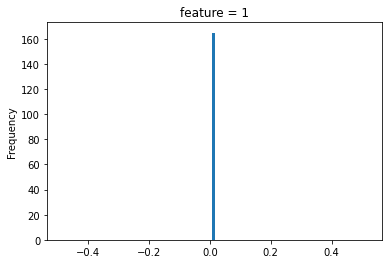

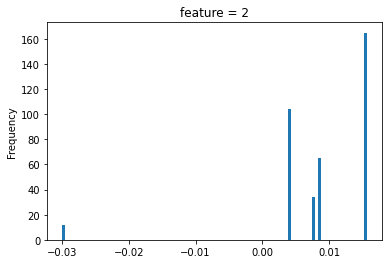

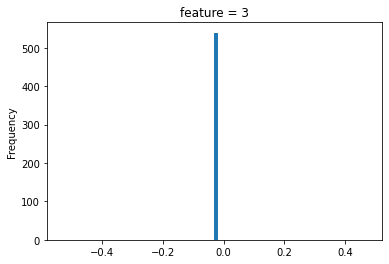

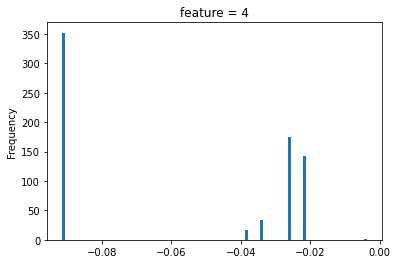

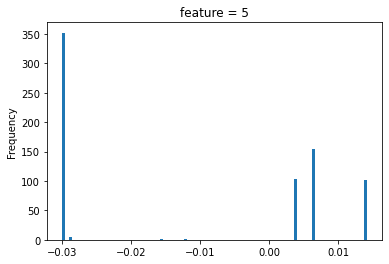

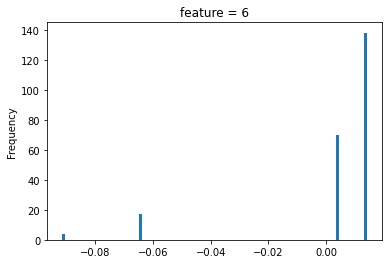

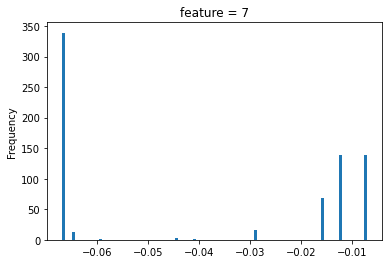

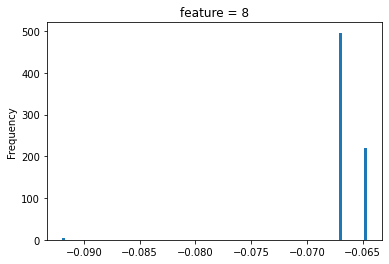

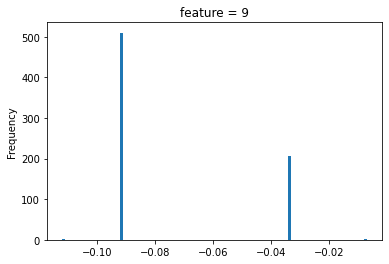

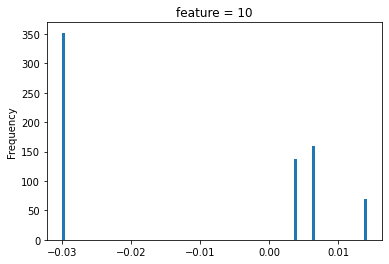

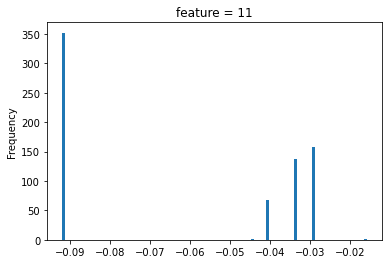

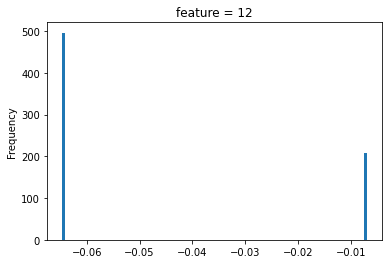

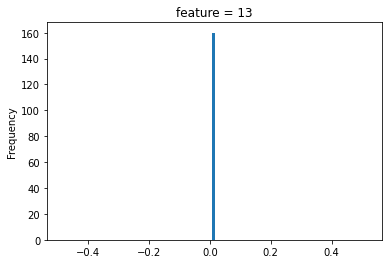

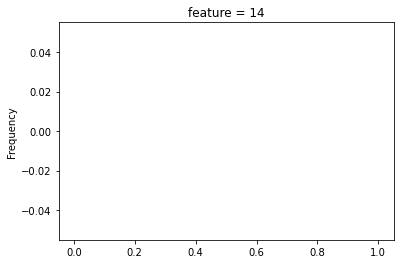

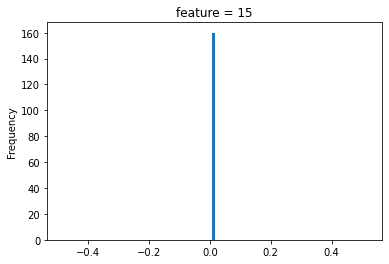

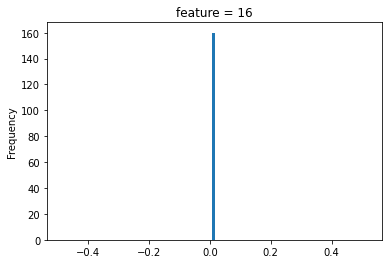

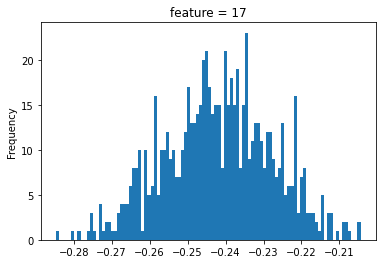

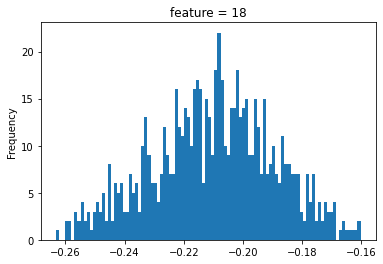

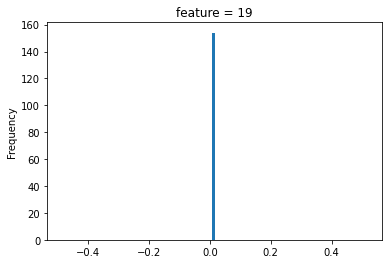

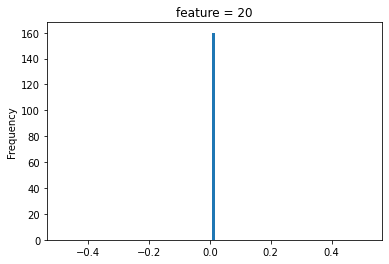

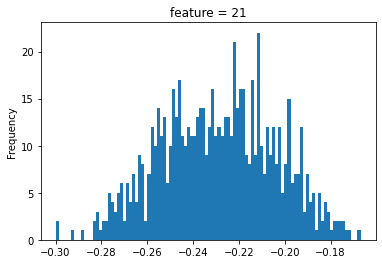

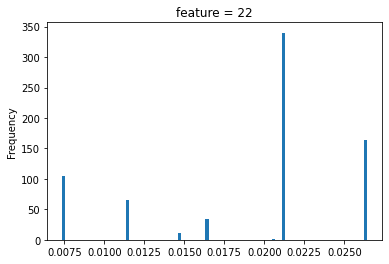

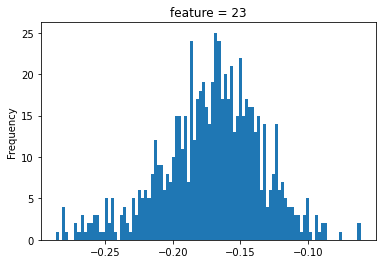

In [ ]:
for i in range(23):
  plt.figure()
  corr_df_new[i].plot.hist(bins = 100)
  plt.title("feature = {0}".format(i+1))

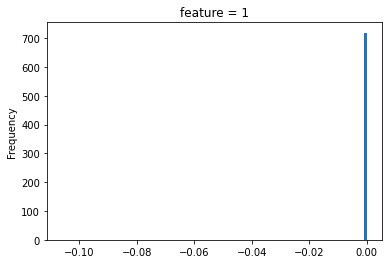

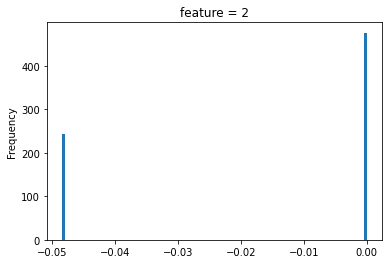

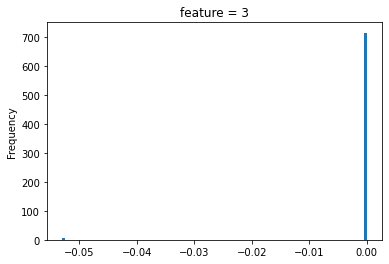

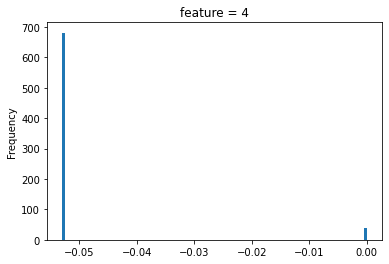

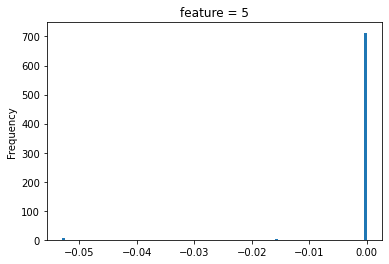

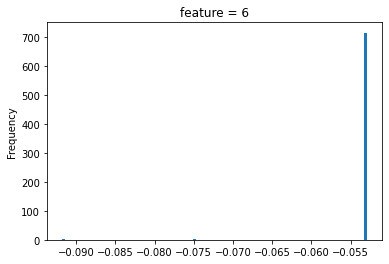

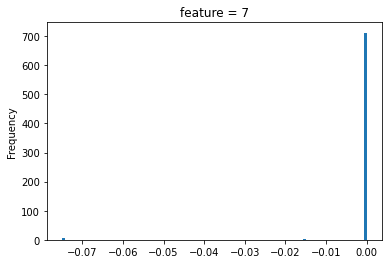

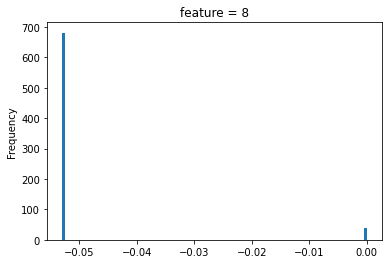

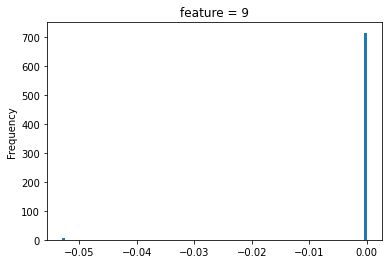

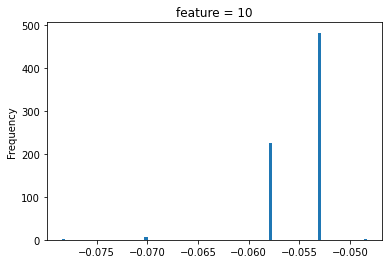

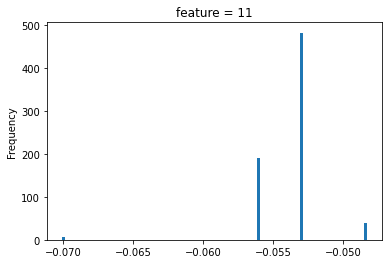

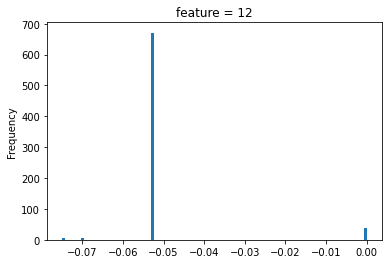

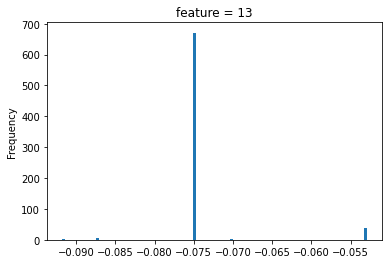

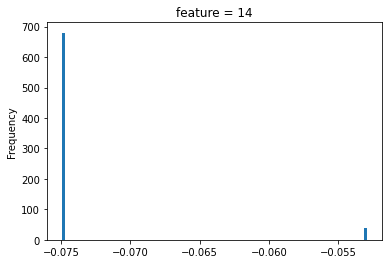

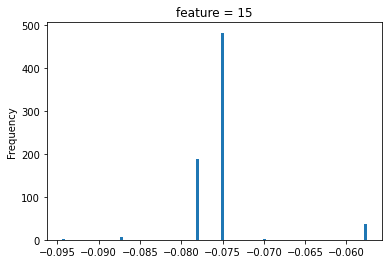

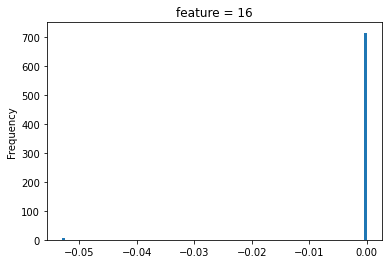

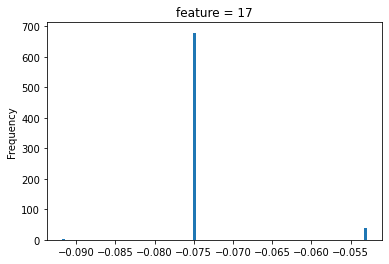

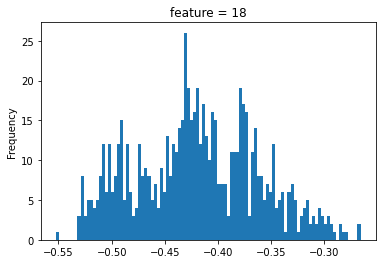

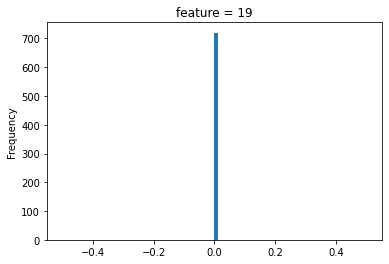

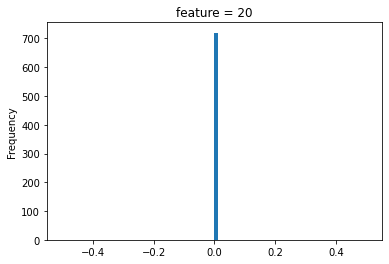

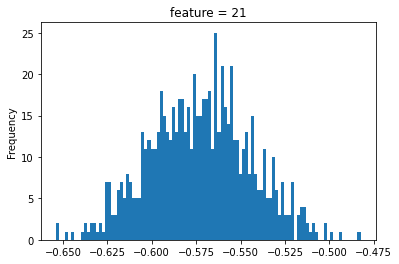

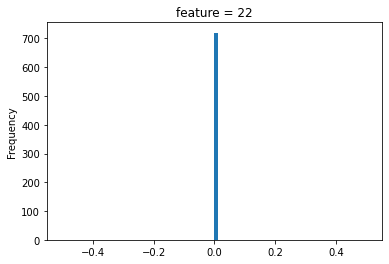

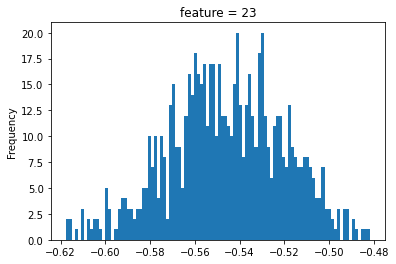

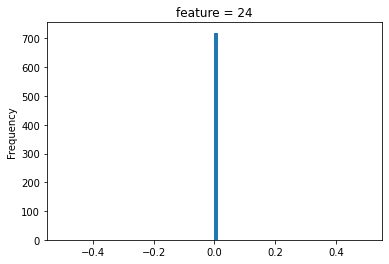

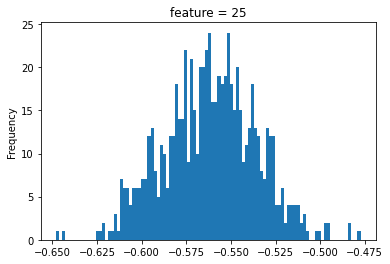

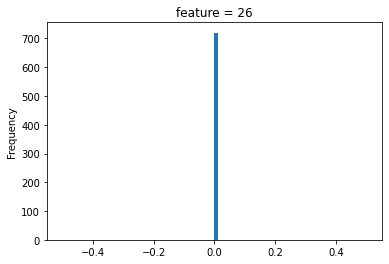

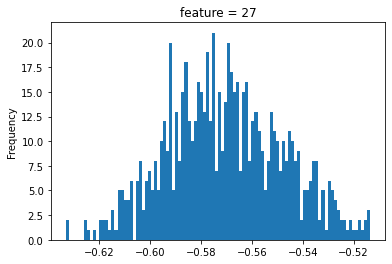

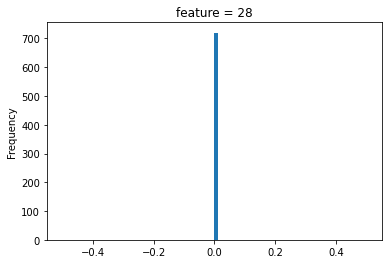

In [ ]:
for i in range(28):
  plt.figure()
  corr_df_new[i].plot.hist(bins = 100)
  plt.title("feature = {0}".format(i+1))

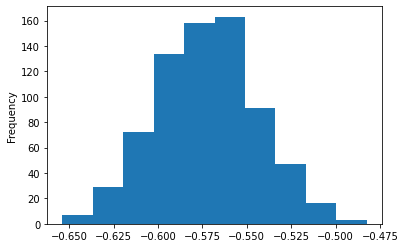

In [ ]:
corr_df_new[20].plot.hist()

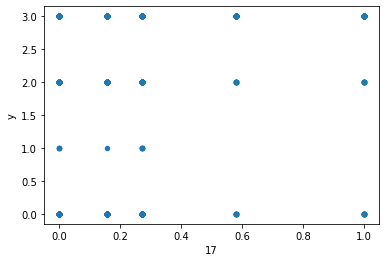

In [ ]:
df_x.plot.scatter(17, 'y')

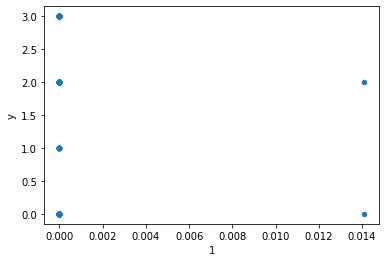

In [ ]:
df_x.plot.scatter(1, 'y')

In [ ]:
corr_df['ts_719']

0    -0.105953
1    -0.048332
2    -0.052965
3    -0.052965
4    -0.052965
5    -0.074909
6    -0.074909
7    -0.052965
8    -0.052965
9    -0.057882
10   -0.055957
11   -0.074909
12   -0.074909
13   -0.052965
14   -0.078164
15   -0.052965
16   -0.074909
17   -0.329092
18         NaN
19         NaN
20   -0.598544
21         NaN
22   -0.532619
23         NaN
24   -0.558779
25         NaN
26   -0.580427
27         NaN
y     1.000000
Name: ts_719, dtype: float64

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# Train LR models on vector data for each alarm, window size and time granuality and save the results to csv file
def train_lr_models_each_alarm(root_dir,window=[30],tg=[5],model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    dataset_name = os.path.split(root_dir)[-1]
    iters=0
    for w in window:
        for t in tg:
            w1,t1=int((w*60)//5), t//5 
            if 720//t1 % w1 !=0:
                continue                  
            data_folder = os.path.join(root_dir,'vector_data_folder')
            if not os.path.exists(data_folder):
                  os.mkdir(data_folder)
            path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'.pickle'
            try:
                with open(path, 'rb') as ds:
                    alarms_ds = pickle.load(ds)
                print('[Loading preprocessed dataset]')
            except:
                alarms_ds= preprocess_for_lr(X,Y, window=w1,tg=t1, detail=0)
                with open(path, 'wb') as ds:
                    pickle.dump(alarms_ds, ds)
            for i,ds in alarms_ds.items():
                # Train Test split
                do_train = True

                x,y=ds
              
                alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                exp_name_=alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)
                exp_name = exp_name_+'_'+'Experiment:'+str(iters)
                if not x.shape[0]>=200:
                    print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                    continue
                
                x_train,x_test,y_train,y_test=train_test_divide(x,y, test_size=0.3)

                if not os.path.exists(data_folder):
                    os.mkdir(data_folder)

                filename = "Vector_"+exp_name_+'.sav'
                filename_nn = "Vector_"+exp_name_+'.h5'
                model_path=os.path.join(root_dir,"models")
                if not os.path.exists(model_path):
                    os.mkdir(model_path)
                if filename in os.listdir(model_path):
                    try:
                        lr = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                        do_train = False
                        train_mae = mean_absolute_error(lr.predict(x_train),y_train)
                        print("[Using pretrained model]")
                    except Exception as e:
                        print(e)
                        continue
                elif filename_nn in os.listdir(model_path):
                    try:
                        nn = tf.keras.models.load_model(os.path.join(model_path,filename_nn))
                        train_mae = mean_absolute_error(nn.predict(x_train),y_train)
                        do_train = False
                        print("[Using pretrained model]")
                    except:
                        continue
                # Optimization LR with GridSearch
                if model=='reg':
                    if do_train:
                        lr = train_lr_cv(x_train,y_train,cv=cv)                        
                    pred=lr.predict(x_test)
                    t_pred=lr.predict(x_train).ravel()
                    model_file = lr
                
                if model=='nn' or model =='NN':
                    if do_train:
                        nn,train_mae = train_nn_dense(x_train,y_train)
                    pred = nn.predict(x_test)
                    model_file = nn
                # Round large values to 3600 and negative to 0
                print(max(pred))
                print(max(y_test))
                pred = np.maximum(pred,0)
                pred[pred>3600]=3600
                t_pred = np.maximum(t_pred,0)
                t_pred[t_pred>3600]=3600
                
                train_mae = mean_absolute_error(t_pred, y_train)

                # Plot original vs predicted values
                if not os.path.exists(os.path.join(root_dir,"plots")):
                    os.mkdir(os.path.join(root_dir,"plots"))
                plot_x(pred.ravel(),y_test.ravel(),os.path.join(root_dir,"plots",exp_name))
                plot_x(t_pred,y_train.ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                # Calculating MAE and saving results
                mae = mean_absolute_error(pred,y_test)
                data=[alarm_name,t,w,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                mae_score = pd.DataFrame([data],columns=column_list)
                mae_scores=mae_scores.append(mae_score, ignore_index=True)
                print("model score: ", lr.score(x_test, y_test))
                print("Experiment: ",iters)
                
                # Saving the model
                save_model(root_dir,filename,model,model_file)
                iters+=1
    csv_path = os.path.join(root_dir,dataset_name+'_vector_regression_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return(csv_path)

TRAIN TENSOR REGRESSION

In [38]:
def train_cp_regressor(x_train,y_train,cp_components=5):
    cpregressor=CPRegressor(cp_components,n_iter_max=300,tol=1e-09,reg_W=10)
    cpregressor.fit(x_train,y_train)
    pred_cv=cpregressor.predict(x_train)
    mae=mean_absolute_error(y_train,pred_cv)
    return cpregressor, mae
    

In [39]:
def train_tucker_regressor(x_train,y_train, rank=5):
    print("3 here")
    tucker = TuckerRegressor(weight_ranks=[rank, rank, rank], n_iter_max=300, tol=1e-09, reg_W=10, verbose=0)
    print("4 here")
    tucker.fit(x_train,y_train)
    print("5 here")
    pred_cv=tucker.predict(x_train)
    print("6 here")
    print("7 here")
    return tucker#, mae
    

In [40]:
def train_CNN(x_train,y_train):
    x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    x_train = torch.unsqueeze(x_train,dim=3)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
    CNN_model.add(Dense(100, activation='relu'))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adam', loss='mean_absolute_percentage_error', metrics=['mae'])
    history=CNN_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), epochs=100, verbose=0, validation_split=0.2, shuffle=False)
    return CNN_model

In [41]:
#Balaji Edits - Added a dropout layer to prevent over fitting
def train_CNN(x_train,y_train, x_test, y_test):
    #x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    #x_train = torch.unsqueeze(x_train,dim=3)
    
    print(x_train.shape)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, (5,5), activation='relu', padding='same', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), data_format='channels_first'))
    CNN_model.add(MaxPooling2D((5,5), padding='same'))
    CNN_model.add(Conv2D(64, (5,5), activation='relu', padding='same'))
    CNN_model.add(MaxPooling2D((5,5), padding='same'))
    CNN_model.add(Conv2D(128, (5,5), activation='relu', padding='same'))
    
    CNN_model.add(Flatten())
    CNN_model.add(Dense(100, activation='relu'))
    CNN_model.add(Dropout(0.5))
    CNN_model.add(Dense(1, activation='relu'))
    CNN_model.compile(optimizer='Adamax', loss='mean_squared_error', metrics=['mae'])
    history=CNN_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), batch_size = 64, epochs=50, verbose=1, validation_data = (x_test.cpu().numpy(), y_test.cpu().numpy()))
    pd.DataFrame(history.history)[['mae', 'val_mae']].plot(marker='o')
    return CNN_model

0 - samples
1 - Features
2 - Timestamp
3 - lag

In [42]:
def train_LSTM(x_train, y_train, x_test, y_test):
    print('1', x_train.shape)
    x_train = torch.transpose(x_train, 1, 2)
    x_test = torch.transpose(x_test, 1, 2)
    #x_train = torch.unsqueeze(x_train,dim=3)
    print('2', x_train.shape)
    LSTM_model = Sequential()
    LSTM_model.add(TimeDistributed(Flatten(input_shape=(x_train.shape[1], x_train.shape[2],x_train.shape[3]))))
    #LSTM_model.add(ConvLSTM2D(128, (3,3), activation = "elu", padding = 'same', input_shape = (x_train[1], x_train[2], x_train[3])))
    LSTM_model.add(LSTM(128, activation = "elu",  dropout = 0.3))
    #LSTM_model.add(Dense(100, activation = "relu"))
    LSTM_model.add(Dense(1, activation = "elu"))
    LSTM_model.compile(optimizer = 'Adamax', loss = "mean_absolute_error", metrics = ['mae'])
    history = LSTM_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), batch_size = 64, epochs = 30, verbose = 1, validation_data = (x_test.cpu().numpy(), y_test.cpu().numpy()))
    print(LSTM_model.summary())
    pd.DataFrame(history.history)[['mae', 'val_mae']].plot(marker = 'o')
    return LSTM_model

In [43]:
def train_LSTM(x_train, y_train, x_test, y_test):
    print('1', x_train.shape)
    x_train = torch.transpose(x_train, 1, 2)
    x_test = torch.transpose(x_test, 1, 2)
    #x_train = torch.unsqueeze(x_train,dim=3)
    print('2', x_train.shape)
    LSTM_model = Sequential()
    LSTM_model.add(TimeDistributed(Flatten(input_shape=(x_train.shape[1], x_train.shape[2],x_train.shape[3]))))
    #LSTM_model.add(ConvLSTM2D(128, (3,3), activation = "elu", padding = 'same', input_shape = (x_train[1], x_train[2], x_train[3])))
    LSTM_model.add(Bidirectional(LSTM(128, activation = "elu",  dropout = 0.3)))
    LSTM_model.add(LSTM(64, activation = "elu",  dropout = 0.3))
    #LSTM_model.add(Dense(100, activation = "relu")
    LSTM_model.add(Dense(1, activation = "elu"))
    LSTM_model.compile(optimizer = 'Adamax', loss = "mean_absolute_error", metrics = ['mae'])
    history = LSTM_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), batch_size = 64, epochs = 30, verbose = 1, validation_data = (x_test.cpu().numpy(), y_test.cpu().numpy()))
    print(LSTM_model.summary())
    pd.DataFrame(history.history)[['mae', 'val_mae']].plot(marker = 'o')
    return LSTM_model

In [44]:
from tensorly.regression.cp_regression import CPRegressor
import tensorly as tl
import torch
tl.set_backend('pytorch')
from sklearn.metrics import mean_absolute_error

# Perform tensor regression using CP regression for all alarms in the dataset directory
def hankle_and_train_tensor_regression(root_dir,window=[30],tg=[5],lag=[30],cp_components=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    dataset_name = os.path.split(root_dir)[-1]
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Lag','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    iters=0
    for w in window:
        for t in tg:
            for l in lag:
                w1,t1=int((w*60)//5), t//5 
                if 720//t1 % w1 !=0:
                    continue   
                data_folder = os.path.join(root_dir,'tensor_data_folder')
                if not os.path.exists(data_folder):
                      os.mkdir(data_folder)
                path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)+'.pickle'
                try:
                    with open(path, 'rb') as ds:
                        alarms_dataset = pickle.load(ds)
                    print('[Loading preprocessed dataset]')

                except:
                    alarms_dataset=preprocess_hanklize_tensors(X,Y, window=w1,tg=t1,lag=l, detail=0)
                    #with open(path, 'wb') as ds:
                        #pickle.dump(alarms_dataset, ds)
                for i,ds in alarms_dataset.items():
                    # Train Test Split
                    x,y=ds
                    if iters ==0:
                      print(y)
                    do_train=True

                    # Alarm Names
                    alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                    exp_name_ =alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)
                    exp_name = exp_name_+'_'+'Experiment:'+str(iters)
                    print(x.shape[0])
                    if not x.shape[0]>=200:
                        print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                        continue

                    x_train,x_test,y_train,y_test=train_test_divide_tensor(x,y.cpu())
                    x_train,x_test = torch.tensor(x_train,device='cuda'),torch.tensor(x_test,device='cuda')
                    y_train,y_test = torch.tensor(y_train,device='cuda'),torch.tensor(y_test,device='cuda')

                    filename = "Tensor_regression_"+exp_name_+'.sav'
                    filename_nn = "Tensor_regression_"+exp_name_+'.h5'
                    model_path=os.path.join(root_dir,"models")
                    if not os.path.exists(model_path):
                        os.mkdir(model_path)
                    if filename in os.listdir(model_path):
                        try:
                            cpregressor = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                            do_train = False
                            train_mae = mean_absolute_error(cpregressor.predict(x_train),y_train)
                            print("[Using pretrained model]")
                        except Exception as e:
                            print(e)
                            continue
                    elif filename_nn in os.listdir(model_path):
                        try:
                            lstm = tf.keras.models.load_model(os.path.join(model_path,filename_nn))
                            train_mae = mean_absolute_error(lstm.predict(x_train),y_train)
                            do_train = False
                            print("[Using pretrained model]")
                        except:
                            print(e)
                            continue
                    # Training
                    if model == 'reg':
                        if do_train:
                            print(x_train.element_size() * x_train.nelement())
                            print("1 here")
                            cpregressor = train_tucker_regressor(x_train,y_train,rank=cp_components)
                            print("2 here")
                        pred=cpregressor.predict(x_test)
                        print("3 here")
                        model_file = cpregressor
                    if model == 'nn' or model == 'NN':
                        print("alarm", i)
                        if do_train:
                            lstm = train_CNN(x_train,y_train, x_test, y_test)
                        #x_test = torch.transpose(tl.tensor(x_test), 1, 2)
                        print("got here!")
                        pred = lstm.predict(x_test.cpu().numpy())
                        print('done with this!!')
                        model_file = lstm
                        
                    # Round large values to 3600 and negative to 0
                    #pred=pred.cpu()
                    print("we reached here!!!")
                    pred = np.maximum(pred,0)
                    pred[pred>3600]=3600
                    t_pred=model_file.predict(x_train.cpu().numpy())
                    t_pred = np.maximum(t_pred,0)
                    t_pred[t_pred>3600]=3600
                    print("here 12")
                    # Plotting
                    if not os.path.exists(os.path.join(root_dir,"plots")):
                       os.mkdir(os.path.join(root_dir,"plots"))
                    plot_x(pred.ravel(),y_test.cpu().numpy().ravel(),os.path.join(root_dir,"plots",exp_name))
                    plot_x(t_pred.ravel(),y_train.cpu().numpy().ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                    # Calculating MAE and saving results
                    mae = mean_absolute_error(y_test.cpu().numpy(),pred)
                    train_mae = mean_absolute_error(t_pred, y_train.cpu().numpy())
                    data=[alarm_name,t,w,l,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                    mae_score = pd.DataFrame([data],columns=column_list)
                    mae_scores=mae_scores.append(mae_score, ignore_index=True)
                    print("Experiment: ",iters)
                    
                    # Saving the models
                    #save_model(root_dir,filename,model,model_file)
                    iters+=1

    csv_path = os.path.join(root_dir,dataset_name+'_tensor_'+model+'_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return csv_path

tg = 5 \\
torch.Size([14448, 12, 28, 2])


In [45]:
root_dir="/content/drive/MyDrive/freelance_Ahamed/13"

In [46]:

cp_components=5            #required for tensor regression

mint=60                          #seconds per minute
minimum_sec=5                    #minimum sampling time in which data was recorded

# Window size in minutes
window = [1]       #window size should be between 0.5 minutes to 60 minutes (should be multiple of minimum and maximum tg)

# Time granuality in seconds
tg = [5]             # Time granuality seconds (how many seconds will be averaged)(must be divisible by 5)

lag=[5]   # lag in seconds (2 means lag of time samples)
# for dr in os.listdir(root_dir):
#     path=os.path.join(root_dir,dr)
#     # Perform Tensor regression on the root_dir
#     print(path)
csv_path=hankle_and_train_tensor_regression(root_dir, window=window, tg=tg, lag=lag, cp_components=cp_components,model='nn')
print("Results saved to: ",csv_path)


tensor([[3540],
        [3480],
        [3420],
        ...,
        [ 120],
        [  60],
        [   0]], device='cuda:0')
18060
alarm 0
torch.Size([14448, 28, 12, 2])
Epoch 1/50
226/226 [==============================] - 50s 9ms/step - loss: 3502781.2456 - mae: 1571.7715 - val_loss: 1214812.3750 - val_mae: 937.7391
Epoch 2/50
226/226 [==============================] - 1s 5ms/step - loss: 1281754.4642 - mae: 958.1014 - val_loss: 1200836.1250 - val_mae: 934.0488
Epoch 3/50
226/226 [==============================] - 1s 5ms/step - loss: 1287762.6608 - mae: 959.3109 - val_loss: 1196615.8750 - val_mae: 932.6805
Epoch 4/50
226/226 [==============================] - 1s 5ms/step - loss: 1261158.3689 - mae: 950.1950 - val_loss: 1180097.1250 - val_mae: 928.2354
Epoch 5/50
226/226 [==============================] - 1s 5ms/step - loss: 1229188.2137 - mae: 942.1202 - val_loss: 1176827.0000 - val_mae: 927.1600
Epoch 6/50
 65/226 [=======>......................] - ETA: 0s - loss: 1242616.1538 - m

KeyboardInterrupt: ignored

TRAIN MATRIX REGRESSION

In [ ]:
def train_CNN(x_train,y_train):
    x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    x_train = np.expand_dims(x_train.cpu().numpy(),axis=2)
    y_train = y_train.cpu().numpy().ravel()

    n_steps=x_train.shape[1]
    n_features=x_train.shape[2]
    print(n_steps,n_features)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3]), data_format='channels_first'))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (1, 1), activation='relu'))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (1, 1), activation='relu'))
    CNN_model.add(Dense(100, activation='relu'))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    print(x_train.shape,y_train.shape)
    history=CNN_model.fit(x_train, y_train, epochs=100, verbose=0, validation_split=0.2, shuffle=False)
    return CNN_model

In [ ]:
# Balaji Edits
def train_CNN(x_train,y_train):
    x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    x_train = np.expand_dims(x_train.cpu().numpy(),axis=2)
    y_train = y_train.cpu().numpy().ravel()
    print("x_train", x_train.shape)
    n_steps=x_train.shape[1]
    n_features=x_train.shape[2]
    print(n_steps,n_features)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(1,x_train.shape[1], x_train.shape[2], x_train.shape[3], x_train.shape[4]), data_format='channels_first'))
    CNN_model.add(MaxPooling2D((3, 3)))
    CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D((3, 3)))
    CNN_model.add(Conv2D(128, (3, 3), activation='relu'))
    CNN_model.add(Dropout(0.3))
    CNN_model.add(Flatten())
    CNN_model.add(Dense(100, activation='relu'))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    print(x_train.shape,y_train.shape)
    history=CNN_model.fit(x_train, y_train, epochs=100, verbose=0, validation_split=0.2, shuffle=False)
    return CNN_model

In [ ]:
# Balaji Edits
def train_CNN(x_train,y_train):
    #x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    #x_train = np.expand_dims(x_train.cpu().numpy(),axis=2)
    y_train = y_train.cpu().numpy().ravel()
    print("x_train", x_train.shape)
    n_steps=x_train.shape[1]
    n_features=x_train.shape[2]
    print(n_steps,n_features)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(1,x_train.shape[1], x_train.shape[2], x_train.shape[3]), data_format='channels_first'))
    CNN_model.add(MaxPooling2D((3, 3)))
    CNN_model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    CNN_model.add(MaxPooling2D((3, 3)))
    CNN_model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    CNN_model.add(Dropout(0.3))
    CNN_model.add(Dense(100, activation='relu'))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    print(x_train.shape,y_train.shape)
    history=CNN_model.fit(x_train, y_train, epochs=100, verbose=0, validation_split=0.2, shuffle=False)
    return CNN_model

In [ ]:
from tensorly.regression.cp_regression import CPRegressor
import tensorly as tl
import torch
tl.set_backend('pytorch')
from sklearn.metrics import mean_absolute_error

# Perform tensor regression using CP regression for all alarms in the dataset directory
def hankle_and_train_matrix_regression(root_dir,window=[30],tg=[5],cp_components=5,model="reg"):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    dataset_name = os.path.split(root_dir)[-1]
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    iters=0
    for w in window:
        for t in tg:
            w1,t1=int((w*60)//5), t//5 
            if 720//t1 % w1 !=0:
                continue   
            data_folder = os.path.join(root_dir,'matrix_data_folder')
            if not os.path.exists(data_folder):
                  os.mkdir(data_folder)
            path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'.pickle'
            try:
                with open(path, 'rb') as ds:
                    alarms_dataset = pickle.load(ds)
                print('[Loading preprocessed dataset]')

            except:
                alarms_dataset=preprocess_hanklize_matrix(X,Y, window=w1,tg=t1, detail=0)
                with open(path, 'wb') as ds:
                    pickle.dump(alarms_dataset, ds)
            for i,ds in alarms_dataset.items():
                # Train Test Split
                x,y=ds
                do_train=True
                
                alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                exp_name_ = alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)
                exp_name = exp_name_+'_'+'Experiment:'+str(iters)
               
                if not x.shape[0]>=200:
                    print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                    continue
                x_train,x_test,y_train,y_test=train_test_divide_tensor(x,y.cpu())
                y_train,y_test = torch.tensor(y_train,device='cuda'),torch.tensor(y_test,device='cuda')

                filename = "Matrix_regression_"+exp_name_+'.sav'
                filename_nn = "Matrix_regression_"+exp_name_+'.h5'
                model_path=os.path.join(root_dir,"models")
                if not os.path.exists(model_path):
                    os.mkdir(model_path)
                if filename in os.listdir(model_path):
                    try:
                        cpregressor = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                        do_train = False
                        train_mae = mean_absolute_error(cpregressor.predict(x_train),y_train)
                        print("[Using pretrained model]")
                    except Exception as e:
                        print(e)
                        continue
                # Training
                if do_train:
                    cpregressor,train_mae=train_cp_regressor(x_train,y_train,cp_components=cp_components)
                pred=cpregressor.predict(x_test)
                model_file = cpregressor

                # Round large values to 3600 and negative to 0
                pred=pred.cpu()
                pred = np.maximum(pred,0)
                pred[pred>3600]=3600
                t_pred=model_file.predict(x_train)
                #t_pred=t_pred.cpu()
                t_pred = np.maximum(t_pred,0)
                t_pred[t_pred>3600]=3600

                # Plotting
                if not os.path.exists(os.path.join(root_dir,"plots")):
                    os.mkdir(os.path.join(root_dir,"plots"))
                plot_x(pred.ravel(),y_test.cpu().numpy().ravel(),os.path.join(root_dir,"plots",exp_name))
                plot_x(t_pred.ravel(),y_train.cpu().numpy().ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                # Calculating MAE and saving results
                mae = mean_absolute_error(y_test.cpu(),pred)
                data=[alarm_name,t,w,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                mae_score = pd.DataFrame([data],columns=column_list)
                mae_scores=mae_scores.append(mae_score, ignore_index=True)
                print("Experiment: ",iters)
                
                # Saving the models
                save_model(root_dir,filename,model,model_file)
                iters+=1
            del alarms_dataset

    csv_path = os.path.join(root_dir,dataset_name+'_matrix_regression_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return csv_path

Running on All folders with multiple window sizes and time granuality

Vector Regression

In [ ]:

mint=60                          #seconds per minute
minimum_sec=5                    #minimum sampling time in which data was recorded

# Window size in minutes
window = [1]      #window size should be between 0.5 minutes to 60 minutes (should be multiple of minimum and maximum tg)

# Time granuality in seconds
tg = [5]             # Time granuality seconds (how many seconds will be averaged)(must be divisible by 5)

# Perform Vector regression on the root_dir
# for dr in os.listdir(root_dir):
#       if not '.ipynb_checkpoints' in dr and not len(os.listdir(os.path.join(root_dir,dr)))==0:
#             path=os.path.join(root_dir,dr)
#             print(path)
csv_path=train_lr_models_each_alarm(root_dir,window=window,tg=tg)
print("Results saved to: ",csv_path)


[Loading preprocessed dataset]
      Iter       Train Loss   Remaining Time 
         1     1072457.8557           27.23m
         2     1068731.2254           25.61m
         3     1065333.1921           23.29m
         4     1059204.0495           21.64m
         5     1053285.9932           20.69m
         6     1049242.3522           19.89m
         7     1046010.9544           20.02m
         8     1040994.9890           19.07m
         9     1038721.9863           18.95m
        10     1034874.7116           18.29m
        20     1008871.6794           14.32m
        30      986762.9242            9.79m
        40      964509.0641            4.98m
        50      951334.4182            0.00s
      Iter       Train Loss   Remaining Time 
         1     1073226.2629           26.31m
         2     1068903.9140           25.68m
         3     1064546.3627           23.96m
         4     1061463.8587           23.75m
         5     1055267.1539           21.93m
         6     1052041

Tensor Regression

Matrix Regression using CP Regression

In [ ]:
cp_components=15              #required for tensor regression

mint=60                          #seconds per minute

minimum_sec=5                    #minimum sampling time in which data was recorded

# Window size in minutes
window = [5]      #window size should be between 0.5 minutes to 60 minutes (should be multiple of minimum and maximum tg)

# Time granuality in seconds
tg = [10]             # Time granuality seconds (how many seconds will be averaged)(must be divisible by 5)

# Perform Tensor regression on the root_dir
# for dr in os.listdir(root_dir):
#     path=os.path.join(root_dir,dr)
#     print(path)
csv_path=hankle_and_train_matrix_regression(root_dir, window=window, tg=tg, cp_components=cp_components)
print("Results saved to: ",csv_path)


DATA PREPARE

In [ ]:
def prepare_data_vector_single_alarm(root_dir,alarm_name,window=30,tg=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    print("Dimensions of Original Dataset:\nX has dimension",X.shape,"\nY has dimension",Y.shape)
    cv=5
    dataset_name = os.path.split(root_dir)[-1]
    print("Machine:",dataset_name)
    w1,t1=int((window*60)//5), tg//5 
    if 720//t1 % w1 !=0:
        print("Setting not valid")   
        sys.exit()             

    df = pd.read_csv(root_dir+'/classes.csv' ,header=None)
    for i, row in df.iterrows():
        if alarm_name in row.values:
            index = i    

    xe,ye = select_alarms(X,Y,alarm_select=index)
    print("Filtering the normal samples, selecting",alarm_name,\
          "from the Original Dataset:\nX has dimension",xe.shape[1:],\
          "\nY has dimension",ye.shape[1:])
    print("Total Number of alarm samples for",alarm_name,"are",ye.shape[1],"samples.")
    print("\nEach sample is average using time granuality and split into windows one by one:")
    alarm_ds = divide_and_create_lr_datasets(xe,list(ye), window=w1, tg=t1, detail=1)
    for i,ds in alarm_ds.items():
        x,y= ds

    print("\nTotal Number of windows are",ye.shape[1],"*",720//t1//w1,"=",x.shape[0])
    print("Shape of X respectively: ",x.shape)
    print("Shape of Y respectively: ",y.shape)
    return x,y

In [ ]:
x,y=prepare_data_vector_single_alarm(root_dir, "A33", tg=5,window=2)
print(x)
print(y)

In [ ]:
def prepare_data_tensor_single_alarm(root_dir,alarm_name,window=30,tg=5,lag=2,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    print("Dimensions of Original Dataset:\nX has dimension",X.shape,"\nY has dimension",Y.shape)
    cv=5
    dataset_name = os.path.split(root_dir)[-1]
    print("Machine:",dataset_name)
    w1,t1=int((window*60)//5), tg//5 
    if 720//t1 % w1 !=0:
        print("Setting not valid")   
        sys.exit()             

    df = pd.read_csv(root_dir+'/classes.csv' ,header=None)
    for i, row in df.iterrows():
        if alarm_name in row.values:
            index = i    

    xe,ye = select_alarms(X,Y,alarm_select=index)
    print("Filtering the normal samples, selecting",alarm_name,\
          "from the Original Dataset:\nX has dimension",xe.shape[1:],\
          "\nY has dimension",ye.shape[1:])
    print("Total Number of alarm samples for",alarm_name,"are",ye.shape[1],"samples.")
    print("\nEach sample is average using time granuality, split into windows and hankelize one by one:")
    alarm_ds = divide_and_create_tr_datasets(xe,list(ye), window=w1, tg=t1, lag=lag,detail=1)
    for i,ds in alarm_ds.items():
        x,y= ds

    print("\nTotal Number of windows are",ye.shape[1],"*",720//t1//w1,"=",x.shape[0])
    print("Shape of X respectively: ",x.cpu().numpy().shape)
    print("Shape of Y respectively: ",y.cpu().numpy().shape)
    return x.cpu().numpy(),y.cpu().numpy()

In [ ]:
x,y=prepare_data_tensor_single_alarm(root_dir, "A315", tg=5,window=2,lag=4)
print(x)
print(y)

In [ ]:
def prepare_data_matrix_single_alarm(root_dir,alarm_name,window=30,tg=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    print("Dimensions of Original Dataset:\nX has dimension",X.shape,"\nY has dimension",Y.shape)
    cv=5
    dataset_name = os.path.split(root_dir)[-1]
    print("Machine:",dataset_name)
    w1,t1=int((window*60)//5), tg//5 
    if 720//t1 % w1 !=0:
        print("Setting not valid")   
        sys.exit()             

    df = pd.read_csv(root_dir+'/classes.csv' ,header=None)
    for i, row in df.iterrows():
        if alarm_name in row.values:
            index = i    

    xe,ye = select_alarms(X,Y,alarm_select=index)
    print("Filtering the normal samples, selecting",alarm_name,\
          "from the Original Dataset:\nX has dimension",xe.shape[1:],\
          "\nY has dimension",ye.shape[1:])
    print("Total Number of alarm samples for",alarm_name,"are",ye.shape[1],"samples.")
    print("\nEach sample is average using time granuality and split into windows one by one:")
    alarm_ds = divide_and_create_matrix_datasets(xe,list(ye), window=w1, tg=t1, detail=1)
    for i,ds in alarm_ds.items():
        x,y= ds

    print("\nTotal Number of windows are",ye.shape[1],"*",720//t1//w1,"=",x.shape[0])
    print("Shape of X respectively: ",x.cpu().numpy().shape)
    print("Shape of Y respectively: ",y.cpu().numpy().shape)
    return x.cpu().numpy(),y.cpu().numpy()

In [ ]:
x,y=prepare_data_matrix_single_alarm(root_dir, "A315", tg=5,window=2)
print(x)
print(y)